## Imports and common functions

In [2]:
# !pip install datasets
!pip install keras-tuner

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
# from datasets import load_dataset
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tensorflow.keras.applications import DenseNet121
import keras_tuner as kt

In [4]:
# Plot training & validation accuracy/loss curves
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')

    plt.show()

## Loading dataset, visualising, and normalising

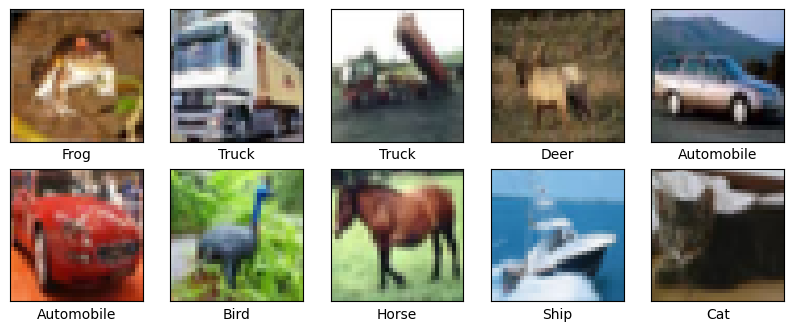

In [5]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# CIFAR-10 classes
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# plot sample images from different classes
def plot_sample_images(x, y, class_names, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)  # Show the image
        # Display the class label of the image
        plt.xlabel(class_names[y[i][0]])
    plt.show()

plot_sample_images(x_train, y_train, class_names, num_samples=10)

In [6]:
# one-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Simple CNN (3 conv. layers)

In [ ]:
# simple CNN model
baseline_model = models.Sequential()

# conv layers
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
baseline_model.add(layers.MaxPooling2D((2, 2)))

baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
baseline_model.add(layers.MaxPooling2D((2, 2)))

baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(64, activation='relu'))

baseline_model.add(layers.Dense(10, activation='softmax'))

# compile model
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# train model
history = baseline_model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test),
                    batch_size=64)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3402 - loss: 1.7864 - val_accuracy: 0.5129 - val_loss: 1.3581
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5457 - loss: 1.2655 - val_accuracy: 0.5789 - val_loss: 1.1863
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6068 - loss: 1.1138 - val_accuracy: 0.6203 - val_loss: 1.0809
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6427 - loss: 1.0159 - val_accuracy: 0.6328 - val_loss: 1.0583
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6798 - loss: 0.9194 - val_accuracy: 0.6646 - val_loss: 0.9603
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6986 - loss: 0.8668 - val_accuracy: 0.6773 - val_loss: 0.9349
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7151 - loss: 0.8124 - val_accuracy: 0.6949 - val_loss: 0.8909
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7328 - loss: 0.7653 - val_accuracy: 0.

In [ ]:
# evaluate on test data
test_loss, test_acc = baseline_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7091 - loss: 0.8582
Test accuracy: 0.7107


### Accuracy and loss curves

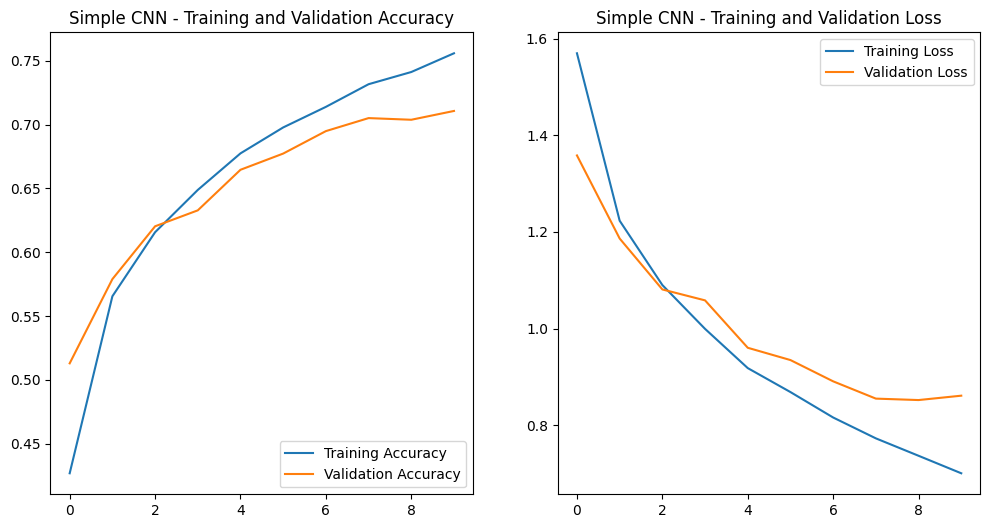

In [ ]:
# Plot for Simple CNN
plot_history(history, 'Simple CNN')

## ResNet50 (ImageNet weights)

In [ ]:
# pre-trained ResNet50 model with ImageNet weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3)) # exclude the top layer

# adding layers on top of ResNet50 base
model = models.Sequential()
model.add(resnet_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))  # Optional fully connected layer
model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 classes

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train model
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_test, y_test),
                    batch_size=64)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 74ms/step - accuracy: 0.5189 - loss: 1.5313 - val_accuracy: 0.2674 - val_loss: 2.8754
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.7235 - loss: 0.8373 - val_accuracy: 0.6830 - val_loss: 0.9804
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.7841 - loss: 0.6521 - val_accuracy: 0.6686 - val_loss: 1.0636
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.7864 - loss: 0.6386 - val_accuracy: 0.6194 - val_loss: 1.2720
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.8085 - loss: 0.5691 - val_accuracy: 0.7111 - val_loss: 0.8945
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8486 - loss: 0.4460 - val_accuracy: 0.6524 - val_loss: 1.2079
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.8516 - loss: 0.4523 - val_accuracy: 0.5681 - val_loss: 1.4745
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.8369 - loss: 0.4861 -

In [ ]:
# evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7788 - loss: 0.9494
Test accuracy: 0.7733


### Accuracy and loss curves

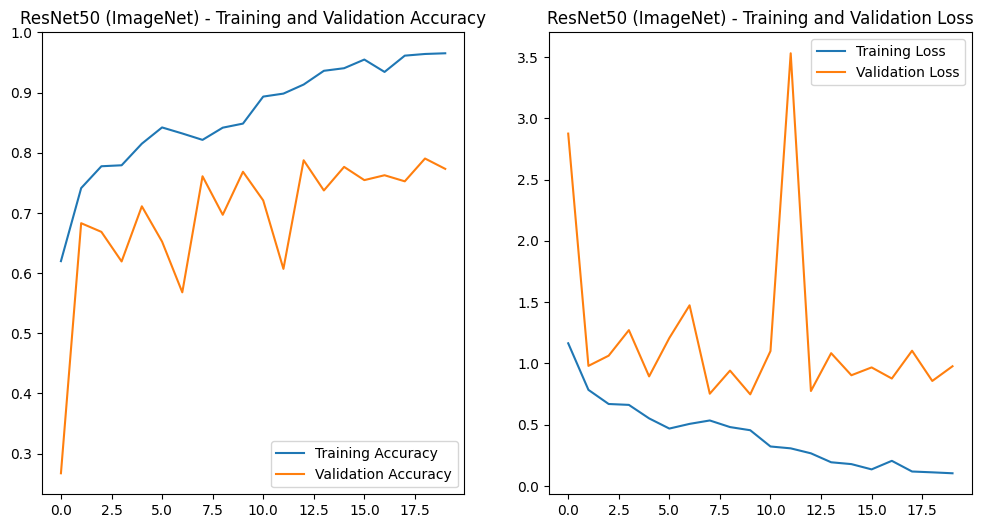

In [ ]:
# Plot for ResNet50
plot_history(history, 'ResNet50 (ImageNet)')

## DenseNet-121 (Keras Tuner)

In [7]:
# Define the hypermodel for DenseNet-121
def build_model(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        # Tune the number of units in the dense layer
        layers.Dense(hp.Int('units', min_value=128, max_value=512, step=64), activation='relu'),
        # Tune the dropout rate
        layers.Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(10, activation='softmax')
    ])

    # Tune the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Reduced number of trials for limited computational resources
    executions_per_trial=1,  # Run each trial once to conserve time and resources
    directory='my_dir',
    project_name='densenet_cifar10_tuning'
)

# Run with fewer epochs for each trial in the tuning phase
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)


# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Trial 5 Complete [00h 10m 28s]
val_accuracy: 0.8112999796867371

Best val_accuracy So Far: 0.8313000202178955
Total elapsed time: 01h 01m 08s


In [13]:
torch.cuda.empty_cache()

In [14]:
# Train the model with the best hyperparameters
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.9089 - loss: 0.2718 - val_accuracy: 0.8476 - val_loss: 0.4851
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 35ms/step - accuracy: 0.9302 - loss: 0.2082 - val_accuracy: 0.8324 - val_loss: 0.5242
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 37ms/step - accuracy: 0.9368 - loss: 0.1869 - val_accuracy: 0.8325 - val_loss: 0.5710
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.9488 - loss: 0.1547 - val_accuracy: 0.8407 - val_loss: 0.5784
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 40ms/step - accuracy: 0.9554 - loss: 0.1338 - val_accuracy: 0.8354 - val_loss: 0.5817


In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8339 - loss: 0.5816
Test accuracy: 0.8354


### Accuracy and loss curves

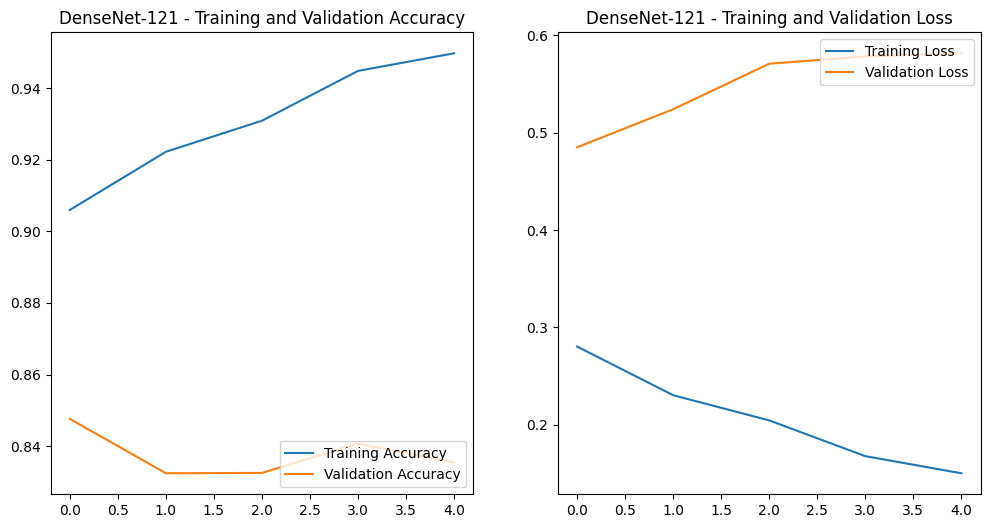

In [16]:
# Plot the curves
plot_history(history, "DenseNet-121")

## EfficientNet-B5 (augmented data)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

datagen.fit(x_train)

In [ ]:
# Load the pre-trained EfficientNet-B5 model, excluding the top layers
efficient_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Build the model by adding custom layers on top of EfficientNet-B5
model = models.Sequential([
    efficient_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the data generator
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=20,
                    validation_data=(x_test, y_test))

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 359s 221ms/step - accuracy: 0.2173 - loss: 2.1559 - val_accuracy: 0.3324 - val_loss: 2.0829
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.4963 - loss: 1.4233 - val_accuracy: 0.6462 - val_loss: 0.9955
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 89ms/step - accuracy: 0.6035 - loss: 1.1429 - val_accuracy: 0.7033 - val_loss: 0.8499
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.6664 - loss: 0.9694 - val_accuracy: 0.7373 - val_loss: 0.7549
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.7028 - loss: 0.8706 - val_accuracy: 0.7648 - val_loss: 0.6831
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.7329 - loss: 0.7872 - val_accuracy: 0.7838 - val_loss: 0.6275
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.7539 - loss: 0.7308 - val_accuracy: 0.7963 - val_loss: 0.5882
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.7732 - loss: 0.6666 - val_accur

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8574 - loss: 0.4349
Test accuracy: 0.8553


### Accuracy and loss curves

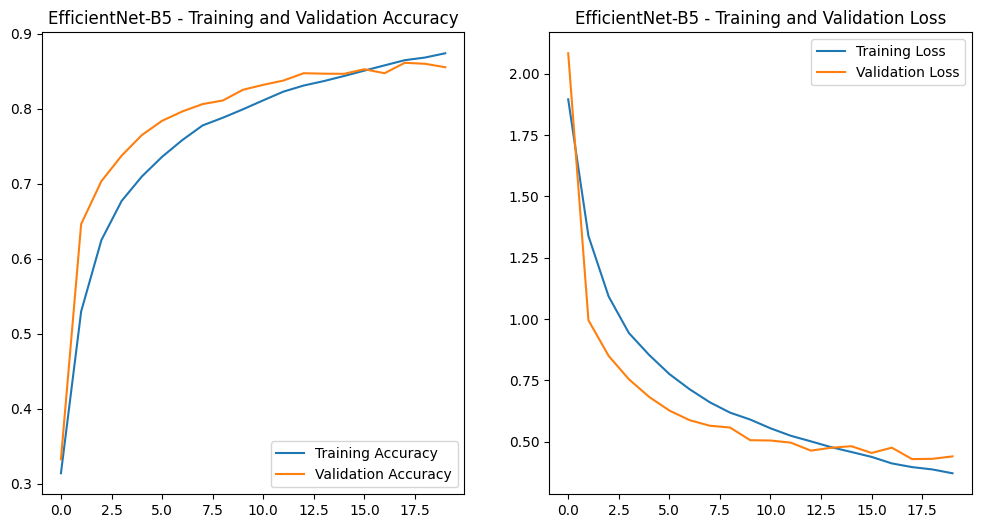

In [ ]:
# Plot the accuracy and loss curves
plot_history(history, 'EfficientNet-B5')